Based on 
Dhara, A and M.K. Sen, 2022, Physics-guided deep autoencoder to overcome the need
for a starting model in full-waveform inversion, The Leading Edge.

[https://doi.org/10.1190/tle41060375.1](https://doi.org/10.1190/tle41060375.1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r /content/drive/MyDrive/Colab/pin_fwi/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# !ipython /content/drive/MyDrive/Colab/pin_fwi/d_obs_deepwave.py

In [4]:
import sys 
sys.path.append("/content/drive/MyDrive/Colab/pin_fwi/")


In [5]:
# sys.path.pop()

In [6]:
# sys.path

In [7]:
from config import *
from networks import Autoencoder

In [8]:
d_obs = torch.load(
    f= PATH + "/data_model/taux_obs_" + PACKAGE + "_" + MODEL + "_" + str(N_SHOTS)
    )
# d_obs = data_normalization(d_obs)
d_obs = d_obs.unsqueeze(0).to(device=DEVICE)

print(d_obs.shape)

torch.Size([1, 3, 150, 447])


In [9]:
criteria = torch.nn.MSELoss(reduction='sum')

autoencoder = Autoencoder(batch_size=BATCH_SIZE, in_channels=N_SHOTS,
                  n_blocks_encoder=N_BLOCKS_ENCODER, n_blocks_decoder=N_BLOCKS_DECODER,
                  final_size_encoder=FINAL_SIZE_ENCODER, initial_shape_decoder=DECODER_INITIAL_SHAPE,
                  nt=NT, nr=N_RECEIVERS, final_spatial_shape=model_shape,
                  m_min=VP_MIN, m_max=VP_MAX,
                  final_out_channels=1
                  )
autoencoder = autoencoder.to(device=DEVICE)



In [10]:
optim_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.5, 0.9))
scheduler_autoencoder = torch.optim.lr_scheduler.StepLR(optim_autoencoder, 200, gamma=0.5)
all_loss = []
    

In [11]:
chp_path = None # PATH + "/results/iter_400_autoencoder_ns60_freqs_152560.pth.tar"
if chp_path:
  load_checkpoint(chp_path, autoencoder, device=DEVICE)

Iteration 1 ===== loss: 278.59614944458013


Iteration 26 ===== loss: 26.804142875803844


Iteration 51 ===== loss: 18.799207632740337


Iteration 76 ===== loss: 11.689098488953379


Iteration 101 ===== loss: 12.40847023907635


Iteration 126 ===== loss: 7.137808617618348


Iteration 151 ===== loss: 7.8936975912915335


Iteration 176 ===== loss: 6.31326060079866


Iteration 201 ===== loss: 4.086349728620714


Iteration 226 ===== loss: 3.000637739068932


Iteration 251 ===== loss: 2.6385635785344577


Iteration 276 ===== loss: 2.3076095349258847


Iteration 301 ===== loss: 2.053928708450662


Iteration 326 ===== loss: 2.0201975310014353


Iteration 351 ===== loss: 2.3134024553000927


Iteration 376 ===== loss: 1.4537307334442933


Iteration 401 ===== loss: 1.4345743062181606


Iteration 426 ===== loss: 1.035028073315819


Iteration 451 ===== loss: 0.933705410402682


Iteration 476 ===== loss: 0.9420091296649641


Iteration 501 ===== loss: 0.9049115414834685


Iteration 526 ===== loss: 0.8073825697518058


Iteration 551 ===== loss: 0.6100210708876451


Iteration 576 ===== loss: 0.8104871252758636


Iteration 601 ===== loss: 0.5575722727096744


Iteration 626 ===== loss: 0.4822652838710282


Iteration 651 ===== loss: 0.4291478119169672


Iteration 676 ===== loss: 0.3916021428174443


Iteration 701 ===== loss: 0.418127863564425


Iteration 726 ===== loss: 0.44192607680128687


Iteration 751 ===== loss: 0.3861609095086654


Iteration 776 ===== loss: 0.41317879925999373


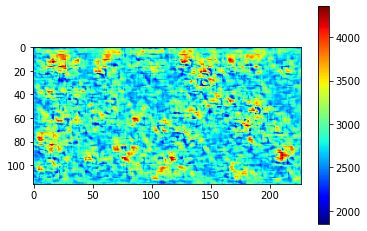

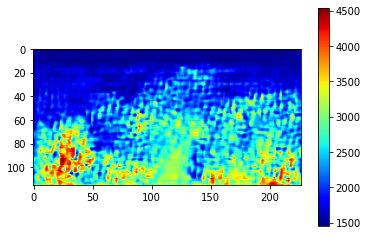

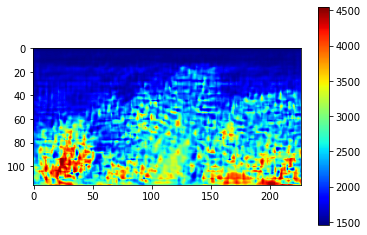

In [12]:
for iter in range(0, ITERATION):
    loss, m, autoencoder = train_fun(Physics=Physics, autoencoder=autoencoder,
                     d_obs=d_obs, freqs=INV_FREQS,
                     optim_autoencoder=optim_autoencoder, criteria=criteria,
                     mini_batches = MINI_BATCHES,
                     src_loc=src_loc, rec_loc=rec_loc, src=src,
                     inpa=inpa, test=None)
    
    all_loss.append(loss)
        
    if iter%25 == 0:
        print(f"Iteration {iter + 1} ===== loss: {all_loss[-1]}")
    if iter%300 == 0:
      # file_name = PATH + "/results/iter_"+ str(iter) + "_autoencoder_ns60_freqs_152560.pth.tar"
      # save_checkpoint(autoencoder, file_name)

      plt.figure()
      plt.imshow(m.cpu().detach(), cmap="jet")
      plt.colorbar()
    scheduler_autoencoder.step()



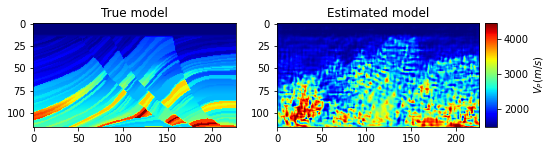

In [22]:
vp, _ = earth_model("marmousi_bl", smooth=15, device="cpu")
vp_min = vp.min()
vp_max = vp.max()

estimated = autoencoder(d_obs)[0,0, ...]
estimated = estimated.cpu().detach()

fig, ax = plt.subplots(1,2, figsize=(8, 4))
im = ax[0].imshow(vp, cmap="jet", vmin=vp_min, 
                   vmax=vp_max) 
ax[0].set_title("True model")

# ax.invert_yaxis()
im = ax[1].imshow(estimated, cmap="jet", vmin=vp_min, 
                   vmax=vp_max) 
ax[1].set_title("Estimated model")
points = ax[1].get_position().get_points()
dy = points[1, 1] - points[0, 1]

cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
cax.yaxis.set_ticks_position("right")
cbar = fig.colorbar(im, cax=cax, orientation="vertical", 
                    extend="neither", label="$V_P (m/s)$"
                    )


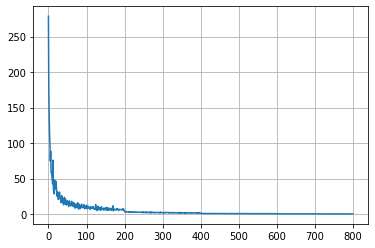

In [25]:
plt.plot(all_loss)
plt.grid()

In [14]:
file_name = PATH + "/results/"+ PACKAGE + "_autoencoder_ns60_freqs_152560.pth.tar"
save_checkpoint(autoencoder, file_name)

=> Saving checkpoint


In [15]:
from PyFWI.seismic_io import save_mat
save_mat(PATH + "/results/"+ PACKAGE, data={"m":m, "res":all_loss}, unique=True)

In [16]:
d_obs.device

device(type='cuda', index=0)

In [17]:
len(all_loss)

800